## Libraries and imports

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import time
import pandas as pd
import numpy as np
import tarfile
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, InputLayer
from keras.models import Model, model_from_json, load_model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from align import AlignDlib
from sklearn.model_selection import train_test_split

## Databases

In [29]:
ATTRS_NAME = "./data/lfw_attributes.txt"

IMAGES_NAME = "./data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "./data/lfw.tgz"

## Image decoder

In [30]:
def decoder(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Image Loader

In [9]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decoder(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                foldername = os.path.split(m.name)
                filename = os.path.split(m.name)[-1]
                fname_splitted = filename[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'Person': person_id, 'imagenum': photo_number, 'Array': img, "File": filename, "Path": foldername })

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    all_photos = all_photos.astype('float32') / 255.0 - 0.5

    # Preserve photo_ids order!
    #all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum'))

    return all_photos, photo_ids

## Apply The Loader

In [10]:
X, photosDf = load_lfw_dataset(use_raw=True, dimx=96, dimy=96)

In [11]:
X

array([[[[ 0.07647061, -0.00588235, -0.08039215],
         [-0.00588235, -0.05686274, -0.14313725],
         [-0.09607843, -0.11960784, -0.21372548],
         ...,
         [-0.05294117, -0.12745097, -0.21372548],
         [-0.04509804, -0.12745097, -0.19019607],
         [-0.0490196 , -0.13529411, -0.19019607]],

        [[ 0.04509807, -0.07647058, -0.14313725],
         [ 0.04901963, -0.02941176, -0.1117647 ],
         [-0.04117647, -0.07254902, -0.17058823],
         ...,
         [-0.04117647, -0.13137254, -0.22156861],
         [-0.01764706, -0.11568627, -0.19019607],
         [-0.02941176, -0.13137254, -0.1980392 ]],

        [[ 0.05686277, -0.12745097, -0.1862745 ],
         [ 0.06470591, -0.05686274, -0.13529411],
         [-0.01764706, -0.07254902, -0.17058823],
         ...,
         [ 0.01372552, -0.08823529, -0.19411764],
         [ 0.01372552, -0.09999999, -0.1862745 ],
         [ 0.00980395, -0.1117647 , -0.19411764]],

        ...,

        [[-0.4882353 , -0.43333334, -0

## Setup Training Model

In [12]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

## Autoencoder Function

In [13]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

## Autoencoder Parameters

In [14]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              3073000   
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


## Save the model after every epoch

In [15]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [16]:
history = autoencoder.fit(x=X, y=X, epochs=20, validation_data=[X_test, X_test])

Train on 13143 samples, validate on 1315 samples
Epoch 1/20
13143/13143 [==============================] - 26s 2ms/step - loss: 0.0099 - accuracy: 0.9119 - val_loss: 0.0047 - val_accuracy: 0.9523
Epoch 2/20
13143/13143 [==============================] - 26s 2ms/step - loss: 0.0038 - accuracy: 0.9570 - val_loss: 0.0030 - val_accuracy: 0.9632
Epoch 3/20
13143/13143 [==============================] - 26s 2ms/step - loss: 0.0026 - accuracy: 0.9652 - val_loss: 0.0022 - val_accuracy: 0.9691
Epoch 4/20
13143/13143 [==============================] - 26s 2ms/step - loss: 0.0021 - accuracy: 0.9691 - val_loss: 0.0018 - val_accuracy: 0.9725
Epoch 5/20
13143/13143 [==============================] - 26s 2ms/step - loss: 0.0017 - accuracy: 0.9721 - val_loss: 0.0015 - val_accuracy: 0.9733
Epoch 6/20
13143/13143 [==============================] - 26s 2ms/step - loss: 0.0015 - accuracy: 0.9734 - val_loss: 0.0014 - val_accuracy: 0.9759
Epoch 7/20
13143/13143 [==============================] - 26s 2ms/ste

## Save and import the model

In [17]:
moment=time.localtime()
name='Model1{}.h5'.format(autoencoder.history.history["val_loss"][-1],moment[2],moment[3],moment[4])
autoencoder.save(name)

In [18]:
encoder.save_weights("./data/models/encoderweights32.h5", overwrite=True)
decoder.save_weights("./data/models/decoderweights32.h5", overwrite=True)
autoencoder.save_weights('./data/models/autoencoderweights32.h5', overwrite=True)
print("Saving weights to disk")

Saving weights to disk


In [19]:
autoencoder.save("./data/models/autoencoder32_save", overwrite=True)
encoder.save("./data/models/encoder32_save", overwrite=True)
decoder.save("./data/models/decoder32_save", overwrite=True)

In [20]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

## Plotting the Model Loss

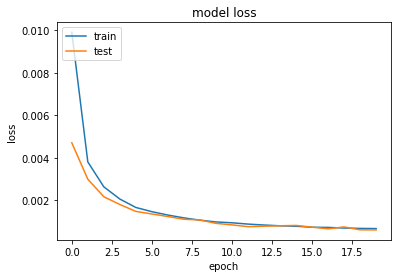

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./graphics/model_loss.png')
plt.show()

## Function to Check Reconstructed Photos

In [22]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

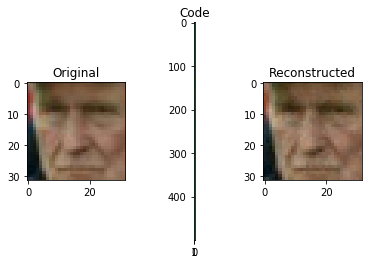

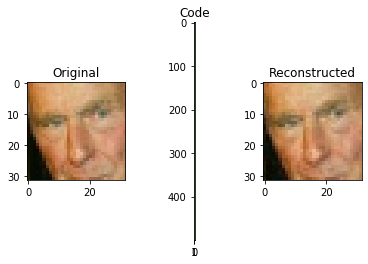

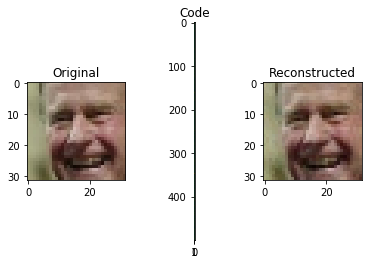

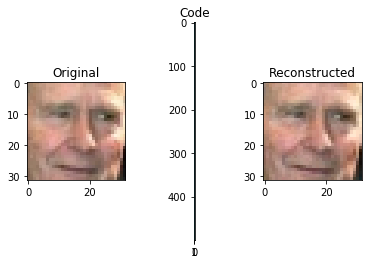

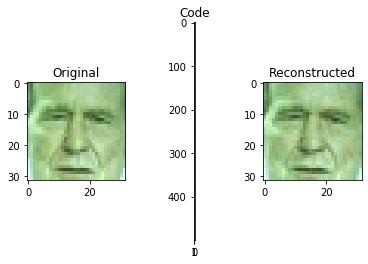

In [23]:
def visualize(img,encoder,decoder,):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
   
    plt.show()
for i in range(5):
    img = X[i]
    visualize(img,encoder,decoder)

## Function to test the model with friends photos

In [24]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [25]:
def load_dataset(path):
    img_data_list=[]
    data_path = path

    data_dir_list = os.listdir(data_path)
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            #input_img_resize=cv2.resize(input_img,(64,64))
            faces = face_cascade.detectMultiScale(input_img, 1.1, 3)
            print (faces[0])
            #input_img_resize=cv2.resize(input_img,(128,128))
            x,y,w,h = faces[0]
            print(x,y,w,h)
            face = input_img[y:y+h,x:x+w]
            face=cv2.resize(face,(32,32))
            #face=face / 255.0 - 0.5
            #face = np.expand_dims(faces, axis=1)
            img_data_list.append(face)

    img_data = np.stack(img_data_list).astype('uint8')
    #img_data = img_data.astype('float32')
    return img_data/ 255.0 - 0.5

In [26]:
X = load_dataset("./data/fotop/")
X.shape

Loaded the images of dataset-Marc

[145 105 200 200]
145 105 200 200
Loaded the images of dataset-jm

[184 100 129 129]
184 100 129 129
Loaded the images of dataset-Clara

[172  62 141 141]
172 62 141 141
Loaded the images of dataset-Celia

[116 105 220 220]
116 105 220 220
Loaded the images of dataset-Cris

[862 816 191 191]
862 816 191 191
Loaded the images of dataset-Felipe

[158 209 161 161]
158 209 161 161
Loaded the images of dataset-Guzman

[222 283 368 368]
222 283 368 368
Loaded the images of dataset-Cesar

[216 220 247 247]
216 220 247 247
Loaded the images of dataset-Julio

[ 44  25 102 102]
44 25 102 102
Loaded the images of dataset-Alex

[137 152 299 299]
137 152 299 299


(10, 32, 32, 3)

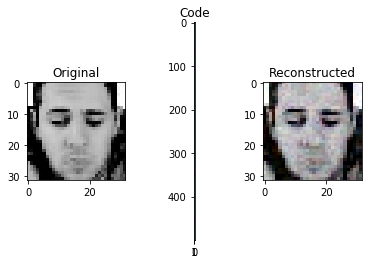

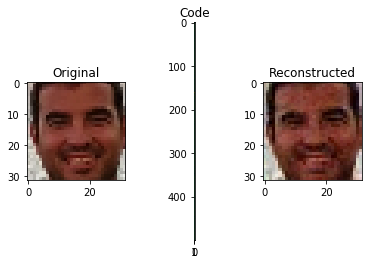

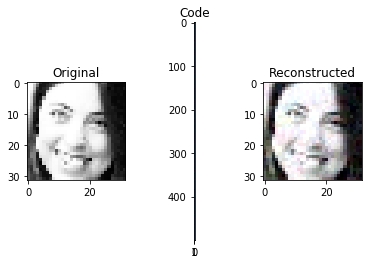

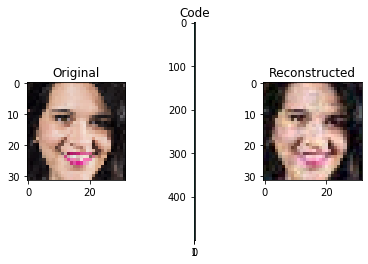

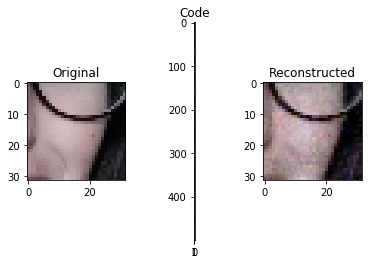

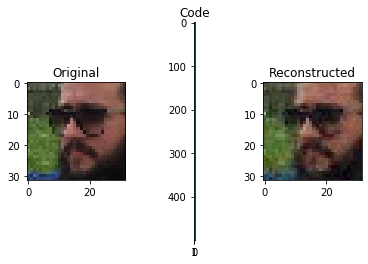

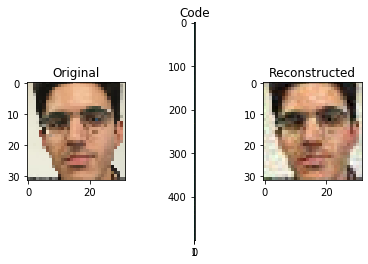

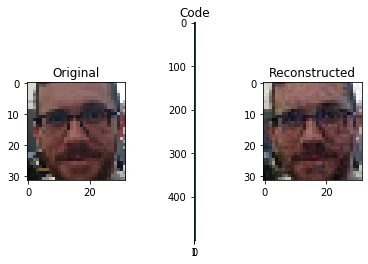

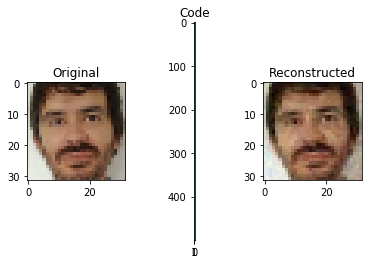

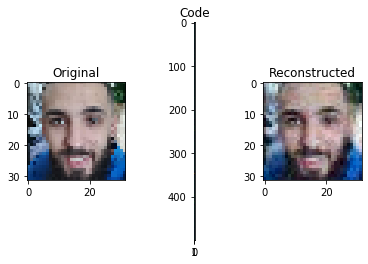

In [27]:
for i in range(10):
    img = X[i]
    visualize(img,encoder,decoder)